# Wasserstein VAE - GAN 

In this example a VAE-GAN is built and trained on the MNIST dataset. This model is basically a join between [1] and [2]

[1] Larsen, Anders Boesen Lindbo, et al. "Autoencoding beyond pixels using a learned similarity metric." arXiv preprint arXiv:1512.09300 (2015).

[2] Arjovsky, Martin, Soumith Chintala, and Léon Bottou. "Wasserstein gan." arXiv preprint arXiv:1701.07875 (2017).

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

%matplotlib inline

Enable memory growth for GPU, it is needed on some systems for convolution to work.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Load the images dataset and normalize it to [-1..1] range. We will use only its train part, so skip the testing.

In [3]:
(x_train, y_train), (_ , _) = tf.keras.datasets.mnist.load_data()
datax = (x_train/127.5)-1
datax = datax.astype("float32")
labels = tf.keras.utils.to_categorical(y_train)

Define the dimensionality of inputs, dimensionality of the hidden space and leaking coefficient. Coefficients $\lambda$ and $\gamma$ will be explained later.

In [4]:
inp_dim = datax.shape[1:3]
n_classes = labels.shape[1]
hidden_dim = 2
a = 0.2
k = 0.25

Firstly, define discriminator model, which maps input image to the similarity score, approximating Wasserstein distance. Note that the outputs of intermediate layers (labelled as preact) form auxiliary output. They will be used later to approximate similarity metrics.

In [5]:
data_input = Input(shape=(inp_dim[0],inp_dim[1],1))

labels_input = Input(shape=(n_classes,))

x = Conv2D(16, (5,5), padding="same")(data_input)
x = LeakyReLU(a)(x)
preact0 = MaxPool2D((2,2))(x)

x = Conv2D(32, (3,3), padding="same")(preact0)
x = LeakyReLU(a)(x)
x = MaxPool2D((2,2))(x)

preact1 = Flatten()(x)
x = Dropout(k)(preact1)

x = Concatenate()([x, labels_input])

x = Dropout(k)(x)
x = Dense(200, activation="linear")(x)
preact2 = LeakyReLU(a)(x)

x = Dropout(k)(preact2)
x = Dense(100, activation="linear")(x)
preact3 = LeakyReLU(a)(x)

discrim_out = Dense(hidden_dim, activation="linear")(preact3)

discriminator = Model([data_input, labels_input], discrim_out, name="discrim")

int_activations = Concatenate()([preact2, preact3])

discriminator_preact = Model([data_input, labels_input], int_activations)

Define generator model. Here, instead of the upsampling layers, a transposed convolution is used, which is roughly equivalent to the normal convolution, followed by upsampling.

In [6]:
hidden_input = Input(shape=(hidden_dim,))

labels_input = Input(shape=(n_classes,))

x = Concatenate()([hidden_input, labels_input])

x = Dropout(k)(x)
x = Dense(256, activation="linear")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

x = Dropout(k)(x)
x = Dense(16*inp_dim[0]//4*inp_dim[1]//4, activation="linear")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

x = Reshape((inp_dim[0]//4, inp_dim[1]//4, 16))(x)

x = Conv2D(32, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

x = Conv2DTranspose(32, (3,3), strides=(2,2), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

x = Conv2DTranspose(32, (5,5), strides=(2,2), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

dec_out = Conv2D(1, (3,3), padding="same", activation="tanh")(x)

decoder = Model([hidden_input, labels_input], dec_out, name="decoder")

Reparametrization trick - instead of sampling from $q(Z|X)=\mathcal{N}(\mu(X,\theta),\Sigma(X,\theta))$, which is indifferentiable, we sample from $\mathcal{N}(0,1)$ and use properties of normal distribution, namely 
$$ X \sim \mathcal{N}(0,1) \\
\Sigma^{1/2}X+\mathbf{\mu} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)$$
to shift mean and scale variance. We've assumed diagonality of $\Sigma$, so multiplication by $\Sigma^{1/2}$ can be replaced with pointwise multiplication by the vector of diagonal standard deviations $\sqrt{\mathbf{\sigma^2}}$, predicted by the encoder.

Since later calculation involve taking log of the variance, it is useful to assume that NN model already predicts log of variance, which will save us from getting NaNs if model output negative number. Thus, here we need to exponentiate log of variance to get $\mathbf{\sigma}^2$, or even better divide by two before exponentiation to directly get $\mathbf{\sigma}$.

In [7]:
def reparametrization(mu, log_sigma):
    batch_size = tf.shape(mu)[0]
    epsilon = tf.random.normal(shape=(batch_size, hidden_dim), mean=0.0, stddev=1.0)
    return tf.math.exp(log_sigma/2)*epsilon+mu

Now we can define encoder model, same as for simple VAE.

In [8]:
data_input = Input(shape=(inp_dim[0],inp_dim[1],1))

labels_input = Input(shape=(n_classes,))

x = Conv2D(8, (5,5), padding="same")(data_input)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)
x = MaxPool2D((2,2))(x)

x = Conv2D(16, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)
x = MaxPool2D((2,2))(x)

x = Flatten()(x)
x = Dropout(k)(x)

x = Concatenate()([x, labels_input])

x = Dropout(k)(x)
x = Dense(200, activation="linear")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

x = Dropout(k)(x)
x = Dense(100, activation="linear")(x)
x = LeakyReLU(a)(x)

mu = Dense(hidden_dim, activation="linear")(x)
log_sigma_diag = Dense(hidden_dim, activation="linear")(x)

enc_out = reparametrization(mu, log_sigma_diag)
encoder = Model([data_input, labels_input], enc_out)

mu_log_sigma = Model([data_input, labels_input], [mu, log_sigma_diag])

Define a function that will sample from the $\hat{X}_g=\epsilon X+(1-\epsilon)X_{g},\,\epsilon\sim\mathcal{U}(0,1)$ on the tensor level.

In [9]:
@tf.function
def random_lincomb(x_real, x_gen):
    batch_size = tf.shape(x_real)[0]
    epsilon = tf.random.uniform((batch_size,1,1,1))
    return epsilon*x_real+(1.0-epsilon)*x_gen

This function generates estimates $$\mathbb{E}_{\hat{{X}}\sim p(\hat{X}_{g})}\big[\max(||\nabla_{\hat{{X}}}D(\hat{{X}})||-1, 0)^{2}\big]$$ by sampling from $\hat{X}_g$, getting gradients at that points and averaging them.  
Scope GradientTape allow differentiation of arbitrary operations inside the scope.   
We need to pass training=True to all operations with model which will be then used to update the weights. This flag is needed for layers, which behave differently in training and testing regimes (such as dropout)

In [10]:
@tf.function
def grad_penalty(real_data, gen_data, labels):
    batch_size = tf.shape(real_data)[0]
    # combine them with real samples and estimate gradients
    lincomb = random_lincomb(real_data, gen_data)
    with tf.GradientTape() as t:
        t.watch(lincomb)
        d_out = discriminator([lincomb, labels], training=True)
        grads = t.gradient(d_out, lincomb)
    # calculate L2 norm (except for batch dimension) and penalty
    l2_grads = tf.math.sqrt(tf.math.reduce_sum(grads**2, axis=[1,2,3]))
    penalty = tf.math.reduce_mean((tf.math.maximum(l2_grads-1.0, 0.0))**2)
    return penalty

Discriminator tries to find the value of Wasserstein loss by optimizing the objective $$\max_{\theta_{1}}\mathbb{E}_{X\sim\mathbb{{X}}}[D(X,\theta_{1})]-\mathbb{E}_{Z\sim p(Z)}[D(G(Z),\theta_{1})]$$
We will need to change the signs to convert it to the minimization problem

In [11]:
@tf.function
def discriminator_loss(real_data, gen_data):
    # real data: D(X), gen_data: D(G(Z))
    loss = -tf.math.reduce_mean(real_data) + tf.math.reduce_mean(gen_data)
    return loss

Now the encoder/generator loss (Wasserstein minimization)

$$ \begin{align}
\min_{\theta_{2}}\mathbb{E}_{X\sim\mathbb{{X}}}[D(X)]-\mathbb{E}_{Z\sim p(Z)}[D(G(Z,\theta_{2}))] &= \min_{\theta_2} -\mathbb{E}_{Z\sim p(Z)}[D(G(Z,\theta_{2}))]
\end{align}$$

In [12]:
@tf.function
def generator_loss(pred):
    # pred: D(G(Z))
    return -tf.math.reduce_mean(pred)

Kullback-Leibler loss between the encoder output distribution and its desired shape $\mathcal{N}(0,I)$

In [13]:
@tf.function
def kl_loss(log_sigma_diag, mu):
    loss = 0.5*(tf.math.reduce_sum(tf.math.exp(log_sigma_diag) + mu**2 - log_sigma_diag, axis=1) - hidden_dim)
    return tf.math.reduce_mean(loss)


Reconstruction loss to ensure that output of the decoder will match $X$.

In [14]:
@tf.function
def reconstuction_loss(x_true, x_reconst):
    loss_a = tf.math.reduce_mean((x_true - x_reconst)**2)
    loss_b = tf.math.reduce_mean(tf.math.abs(x_true - x_reconst))
    return  loss_a + loss_b

Now save the trainable variables (parameters) of all models to the variables. This is needed because we will frequently update them, while direct call referencing as discriminator.trainable_variables is slow, since TF is looking for all variables on the access to it.  
Instantiate the optimizers used (according to the original article), gradient penalty coefficient $\lambda$ and $\gamma$ - a reconstruction loss weight.

In [15]:
discr_trainable_vars = discriminator.trainable_variables
enc_trainable_vars = encoder.trainable_variables
dec_trainable_vars = decoder.trainable_variables

vae_trainable_vars = enc_trainable_vars+dec_trainable_vars

discr_optimizer = Adam(lr=3e-4, beta_1=0.5, beta_2=0.9)
dec_optimizer =  Adam(lr=3e-4, beta_1=0.5, beta_2=0.9)
enc_optimizer =  Adam(lr=3e-4, beta_1=0.5, beta_2=0.9)

lmbd = 10.0
gamma = 1.0

The structure of the network is now very different from the classical tf.keras models, so we will not use methods like .fit but will directly update weights of the models by calling optimizer.apply_gradients. The train_discriminator function trains discriminator by increasing distance (Wasserstein approximation) between (real, encoded) and (real, generated) pairs.

In [16]:
@tf.function
def train_discriminator(data_batch, labels_batch):
    batch_size = tf.shape(data_batch)[0]
    # sample from p(Z)
    noise = tf.random.normal((batch_size, hidden_dim))
    # sample from q(Z|X)
    encoded = encoder([data_batch, labels_batch], training=True)
    # decode both latent representations
    generated = decoder([noise, labels_batch], training=True)
    decoded = decoder([encoded, labels_batch], training=True)
    
    with tf.GradientTape() as t:
        # get predictions from discriminator
        discr_pred_true = discriminator([data_batch, labels_batch], training=True)
        discr_pred_gen = discriminator([generated, labels_batch], training=True)
        discr_pred_dec = discriminator([decoded, labels_batch], training=True)

        # calculate the loss, i.e. approximation of Wass. metric 
        # between real, generated and real, decoded pairs
        wass_loss1 = discriminator_loss(discr_pred_true, discr_pred_gen)
        wass_loss2 = discriminator_loss(discr_pred_true, discr_pred_dec)
        wass_loss = wass_loss1 + wass_loss2
        # get the gradient penalty and combine them to form total loss
        penalty = grad_penalty(data_batch, generated, labels_batch)
        total_loss = wass_loss+lmbd*penalty
        # calculate gradients of total loss w.r.t. discriminator parameters
        grads = t.gradient(total_loss, discr_trainable_vars)
    # update the weights, according to the calculated gradients
    res_loss = discr_optimizer.apply_gradients(zip(grads, discr_trainable_vars))
    return wass_loss, penalty
    
    

Update decoder weights.

In [17]:
@tf.function
def train_decoder(data_batch, labels_batch):
    batch_size = tf.shape(labels_batch)[0]
    # sample from q(Z|X)
    encoded_batch = encoder([data_batch, labels_batch])

    with tf.GradientTape() as t:
        # decode latent reprezentation
        decoded_batch = decoder([encoded_batch, labels_batch], training=True)
        # get the discriminator preactivations
        preact_a = discriminator_preact([data_batch, labels_batch], training=True)
        preact_b = discriminator_preact([decoded_batch, labels_batch], training=True)
        # to calculate the reconstruction loss between them
        r_loss = gamma*reconstuction_loss(preact_a, preact_b)
        # and simultaniously try to minimize the Wasserstein distance
        discr_predicted = discriminator([decoded_batch, labels_batch], training=True)
        wass_loss = generator_loss(discr_predicted)
        total_loss = r_loss + wass_loss
        # combine the losses and update parameters
        grads_dec = t.gradient(total_loss, dec_trainable_vars)
    
    dec_optimizer.apply_gradients(zip(grads_dec, dec_trainable_vars))
    return r_loss, wass_loss

And encoder weights

In [18]:
@tf.function
def train_encoder(data_batch, labels_batch):
    batch_size = tf.shape(labels_batch)[0]
    
    with tf.GradientTape() as t:
        # get the disctiminator preactivations for real and reconstructed data
        encoded_batch = encoder([data_batch, labels_batch], training=True)
        decoded_batch = decoder([encoded_batch, labels_batch], training=True)
        
        preact_a = discriminator_preact([data_batch, labels_batch], training=True)
        preact_b = discriminator_preact([decoded_batch, labels_batch], training=True)
        # to calculate the reconstruction loss
        r_loss = reconstuction_loss(preact_a, preact_b)
        # combine it with KL loss
        mu, log_sigma = mu_log_sigma([data_batch, labels_batch], training=True)
        k_loss = kl_loss(mu, log_sigma)
        total_loss = r_loss + k_loss
        grads_enc = t.gradient(total_loss, enc_trainable_vars)
    # update encoder weights
    enc_optimizer.apply_gradients(zip(grads_enc, enc_trainable_vars))

    return r_loss, k_loss
        

A tiny helper function to shuffle the dataset after end of epoch.

In [19]:
def shuffle(X, Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], Y[indices]

Define the training parameters, including number of repeatition during training of discriminator (5, according to the original article), batch size, number of epochs, number of extra steps for discriminator training and visualization frequency.

In [20]:
n_discr = 10
batch_size = 64
n_epochs = 30
summary_every_batches = 100
plot_every_epochs = 5

Define a helper function to visualize the images. It investigates hidden space by sampling points on a $[-1,1]\times[-1,1]$ grid and generated images, with this points as Z.

In [21]:
def grid_images(generator, im_idx, grid = (10, 10)):
    c=1.2
    x = np.linspace(-c, c, grid[0])
    y = np.linspace(-c, c, grid[1])
    XX,YY = np.meshgrid(x, y)
    noisegrid = np.vstack([XX.flatten(), YY.flatten()]).T
    #noisegrid = np.random.normal(size=(grid[0]*grid[1], hidden_dim))
    labs = np.repeat(tf.keras.utils.to_categorical([im_idx], 10), grid[0]*grid[1], axis=0)
    generated = generator([noisegrid, labs])
    plt.figure(figsize=(5,5))
    idx=1
    for im in generated:
        plt.subplot(grid[0], grid[1], idx)
        plt.imshow(np.squeeze(im), cmap="gray")
        idx+=1
        plt.axis("off")
    plt.tight_layout(0)
    

Finally, train the network as follows  
1) Sample a batch of data from dataset  
2) Train discriminator with this sample for n_discr times.  
3) Update weights of generator to reduce the Wasserstain distance, approximated by discriminator and to increase similarity between real and generated data.
4) Each summary_every_batches iteration print the summary.
  
Note that the approximated Wasserstein loss is converging to lower values as model trains.

Epoch 0
W dist: -0.111, pen: 0.000, enc rec 0.201, enc KL 2.026, dec rec 0.202, dec W 0.312
W dist: 15.179, pen: 0.321, enc rec 4.206, enc KL 0.893, dec rec 4.130, dec W -2.503
W dist: 6.171, pen: 0.093, enc rec 5.525, enc KL 0.662, dec rec 5.323, dec W -4.939
W dist: 5.449, pen: 0.047, enc rec 5.818, enc KL 0.481, dec rec 6.057, dec W -5.971
W dist: 3.867, pen: 0.040, enc rec 5.371, enc KL 0.490, dec rec 5.281, dec W -4.565
W dist: 2.253, pen: 0.027, enc rec 4.726, enc KL 0.394, dec rec 4.526, dec W -5.561
W dist: 2.756, pen: 0.023, enc rec 4.312, enc KL 0.393, dec rec 4.268, dec W -5.426
W dist: 2.416, pen: 0.030, enc rec 3.663, enc KL 0.341, dec rec 3.587, dec W -3.676
W dist: 1.813, pen: 0.021, enc rec 3.770, enc KL 0.276, dec rec 3.840, dec W -3.656
W dist: 4.150, pen: 0.044, enc rec 3.748, enc KL 0.238, dec rec 3.836, dec W -3.290

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting

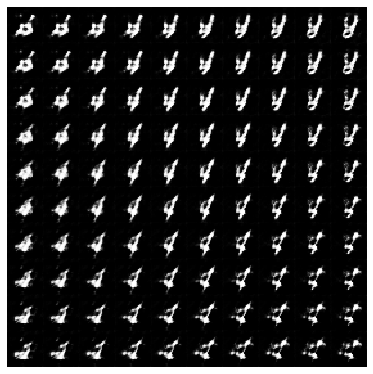

Epoch 1
W dist: 1.247, pen: 0.048, enc rec 3.530, enc KL 0.204, dec rec 3.346, dec W -2.359
W dist: 2.789, pen: 0.028, enc rec 3.473, enc KL 0.212, dec rec 3.417, dec W -2.136
W dist: 2.441, pen: 0.033, enc rec 3.213, enc KL 0.181, dec rec 3.151, dec W -2.331
W dist: 3.424, pen: 0.028, enc rec 2.898, enc KL 0.187, dec rec 2.902, dec W -1.544
W dist: 3.258, pen: 0.030, enc rec 2.524, enc KL 0.165, dec rec 2.569, dec W -1.398
W dist: 2.564, pen: 0.032, enc rec 2.395, enc KL 0.158, dec rec 2.255, dec W -1.780
W dist: 3.049, pen: 0.027, enc rec 2.330, enc KL 0.125, dec rec 2.312, dec W -0.879
W dist: 2.548, pen: 0.030, enc rec 2.234, enc KL 0.143, dec rec 2.240, dec W -1.145
W dist: 3.195, pen: 0.019, enc rec 2.129, enc KL 0.108, dec rec 2.123, dec W -1.046
W dist: 2.376, pen: 0.018, enc rec 2.001, enc KL 0.113, dec rec 1.901, dec W -0.923
Epoch 2
W dist: 2.780, pen: 0.023, enc rec 1.860, enc KL 0.119, dec rec 1.867, dec W -1.440
W dist: 2.553, pen: 0.024, enc rec 1.657, enc KL 0.098, dec 

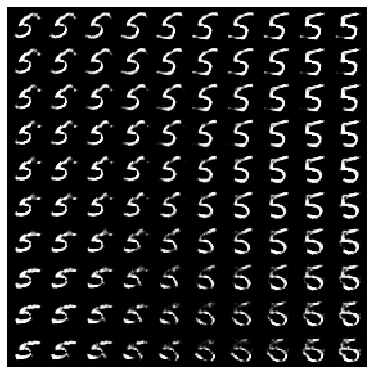

Epoch 6
W dist: 2.308, pen: 0.018, enc rec 0.856, enc KL 0.017, dec rec 0.904, dec W -1.401
W dist: 2.415, pen: 0.026, enc rec 0.918, enc KL 0.018, dec rec 0.906, dec W -1.862
W dist: 2.175, pen: 0.014, enc rec 0.815, enc KL 0.015, dec rec 0.825, dec W -2.140
W dist: 2.107, pen: 0.015, enc rec 0.805, enc KL 0.015, dec rec 0.884, dec W -1.653
W dist: 2.081, pen: 0.020, enc rec 0.851, enc KL 0.015, dec rec 0.865, dec W -1.909
W dist: 2.478, pen: 0.018, enc rec 0.899, enc KL 0.013, dec rec 0.854, dec W -2.526
W dist: 2.750, pen: 0.011, enc rec 0.790, enc KL 0.016, dec rec 0.818, dec W -1.828
W dist: 2.131, pen: 0.023, enc rec 0.833, enc KL 0.012, dec rec 0.866, dec W -1.235
W dist: 2.856, pen: 0.027, enc rec 0.878, enc KL 0.017, dec rec 0.865, dec W -1.340
W dist: 1.813, pen: 0.013, enc rec 0.827, enc KL 0.016, dec rec 0.803, dec W -1.860
Epoch 7
W dist: 3.343, pen: 0.032, enc rec 0.824, enc KL 0.013, dec rec 0.864, dec W -1.981
W dist: 3.027, pen: 0.033, enc rec 0.879, enc KL 0.012, dec 

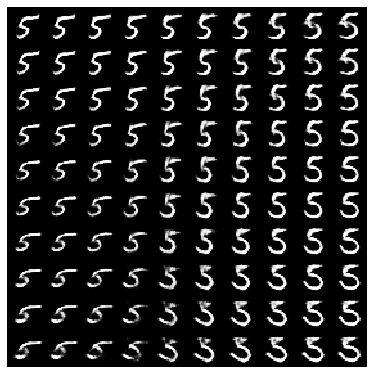

Epoch 11
W dist: 2.472, pen: 0.016, enc rec 0.819, enc KL 0.007, dec rec 0.861, dec W -1.553
W dist: 2.359, pen: 0.023, enc rec 0.795, enc KL 0.005, dec rec 0.820, dec W -2.560
W dist: 1.076, pen: 0.018, enc rec 0.822, enc KL 0.005, dec rec 0.827, dec W -2.432
W dist: 2.172, pen: 0.015, enc rec 0.743, enc KL 0.005, dec rec 0.795, dec W -2.402
W dist: 2.925, pen: 0.017, enc rec 0.819, enc KL 0.004, dec rec 0.837, dec W -2.902
W dist: 1.953, pen: 0.018, enc rec 0.764, enc KL 0.006, dec rec 0.787, dec W -2.910
W dist: 1.258, pen: 0.020, enc rec 0.791, enc KL 0.005, dec rec 0.772, dec W -2.999
W dist: 2.824, pen: 0.019, enc rec 0.813, enc KL 0.004, dec rec 0.804, dec W -2.906
W dist: 1.007, pen: 0.019, enc rec 0.855, enc KL 0.007, dec rec 0.817, dec W -3.268
W dist: 2.120, pen: 0.013, enc rec 0.842, enc KL 0.005, dec rec 0.812, dec W -3.359
Epoch 12
W dist: 2.123, pen: 0.014, enc rec 0.754, enc KL 0.005, dec rec 0.815, dec W -2.328
W dist: 1.539, pen: 0.015, enc rec 0.784, enc KL 0.004, de

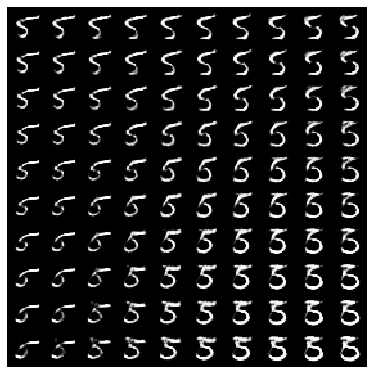

Epoch 16
W dist: 0.742, pen: 0.020, enc rec 0.776, enc KL 0.002, dec rec 0.842, dec W -3.894
W dist: 1.254, pen: 0.017, enc rec 0.733, enc KL 0.003, dec rec 0.790, dec W -3.585
W dist: 1.569, pen: 0.019, enc rec 0.821, enc KL 0.003, dec rec 0.822, dec W -3.398
W dist: 2.235, pen: 0.016, enc rec 0.768, enc KL 0.003, dec rec 0.774, dec W -3.001
W dist: 1.394, pen: 0.020, enc rec 0.793, enc KL 0.002, dec rec 0.822, dec W -3.406
W dist: 3.256, pen: 0.018, enc rec 0.814, enc KL 0.003, dec rec 0.830, dec W -3.577
W dist: 1.535, pen: 0.020, enc rec 0.792, enc KL 0.003, dec rec 0.771, dec W -4.455
W dist: 2.349, pen: 0.041, enc rec 0.833, enc KL 0.003, dec rec 0.737, dec W -4.719
W dist: 2.983, pen: 0.022, enc rec 0.776, enc KL 0.003, dec rec 0.836, dec W -2.932
W dist: 1.593, pen: 0.023, enc rec 0.760, enc KL 0.003, dec rec 0.794, dec W -4.764
Epoch 17
W dist: 2.197, pen: 0.014, enc rec 0.829, enc KL 0.003, dec rec 0.785, dec W -3.889
W dist: 1.595, pen: 0.016, enc rec 0.806, enc KL 0.002, de

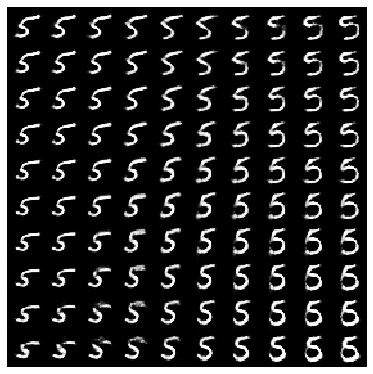

Epoch 21
W dist: 0.765, pen: 0.016, enc rec 0.873, enc KL 0.002, dec rec 0.823, dec W -5.413
W dist: 2.470, pen: 0.017, enc rec 0.853, enc KL 0.002, dec rec 0.798, dec W -3.924
W dist: 1.409, pen: 0.023, enc rec 0.784, enc KL 0.003, dec rec 0.827, dec W -4.837
W dist: 2.341, pen: 0.014, enc rec 0.760, enc KL 0.002, dec rec 0.752, dec W -5.712
W dist: 1.162, pen: 0.025, enc rec 0.863, enc KL 0.002, dec rec 0.823, dec W -4.112
W dist: 0.450, pen: 0.028, enc rec 0.855, enc KL 0.002, dec rec 0.810, dec W -6.216
W dist: 1.072, pen: 0.016, enc rec 0.750, enc KL 0.002, dec rec 0.794, dec W -5.903
W dist: 1.575, pen: 0.019, enc rec 0.786, enc KL 0.003, dec rec 0.748, dec W -4.027
W dist: 0.997, pen: 0.017, enc rec 0.804, enc KL 0.002, dec rec 0.801, dec W -4.882
W dist: 2.633, pen: 0.019, enc rec 0.835, enc KL 0.003, dec rec 0.848, dec W -4.765
Epoch 22
W dist: 3.147, pen: 0.032, enc rec 0.743, enc KL 0.003, dec rec 0.744, dec W -4.951
W dist: 0.427, pen: 0.026, enc rec 0.784, enc KL 0.003, de

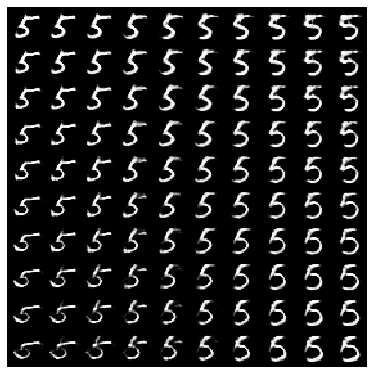

Epoch 26
W dist: 1.246, pen: 0.019, enc rec 0.821, enc KL 0.002, dec rec 0.888, dec W -5.154
W dist: 1.317, pen: 0.008, enc rec 0.774, enc KL 0.002, dec rec 0.782, dec W -5.938
W dist: 1.266, pen: 0.015, enc rec 0.834, enc KL 0.002, dec rec 0.794, dec W -5.586
W dist: 2.319, pen: 0.015, enc rec 0.816, enc KL 0.002, dec rec 0.844, dec W -5.977
W dist: 1.330, pen: 0.009, enc rec 0.873, enc KL 0.001, dec rec 0.793, dec W -5.061
W dist: 1.287, pen: 0.021, enc rec 0.849, enc KL 0.002, dec rec 0.848, dec W -6.259
W dist: 1.464, pen: 0.024, enc rec 0.822, enc KL 0.002, dec rec 0.856, dec W -5.981
W dist: 2.052, pen: 0.037, enc rec 0.825, enc KL 0.003, dec rec 0.932, dec W -5.181
W dist: 1.110, pen: 0.018, enc rec 0.873, enc KL 0.002, dec rec 0.755, dec W -5.623
W dist: 2.030, pen: 0.017, enc rec 0.846, enc KL 0.003, dec rec 0.872, dec W -5.826
Epoch 27
W dist: 3.065, pen: 0.012, enc rec 0.857, enc KL 0.003, dec rec 0.837, dec W -4.748
W dist: 0.975, pen: 0.018, enc rec 0.906, enc KL 0.002, de

In [22]:
for epoch in range(n_epochs):
    print("Epoch", epoch)
    batch_idx = 0
    # iterating over data in dataset
    for data_idx in range(0, datax.shape[0], batch_size):
        data_batch = datax[data_idx:data_idx + batch_size, :, :, np.newaxis]
        labels_batch = labels[data_idx:data_idx + batch_size]
        # discriminator is trained on each epochs
        d_loss, penalty = train_discriminator(data_batch, labels_batch)
        # while encoder and decoder are trained each n_discr epoch, to ensure convergence of D
        if batch_idx % n_discr == 0:
            r_loss_enc, k_loss = train_encoder(data_batch, labels_batch)
            r_loss_dec, w_loss = train_decoder(data_batch, labels_batch)

         # every nth epoch, print summary
        if batch_idx % summary_every_batches == 0:
            print("W dist: {:.3f}, pen: {:.3f}, enc rec {:.3f}, enc KL {:.3f}, \
dec rec {:.3f}, dec W {:.3f}".format(-d_loss, penalty, r_loss_enc, k_loss, r_loss_dec, w_loss))

        batch_idx += 1
    # visualize
    if epoch % plot_every_epochs == 0:
        grid_images(decoder, 5)
        #reconstr()
        plt.show()
    # shuffle in the end of epoch
    datax, labels = shuffle(datax, labels)

Have a look how the VAE-GAN reconstructs input data.

In [23]:
def plot_reconstr(generator):
    n=8
    hidden_repr = encoder([datax[:8,:,:,np.newaxis], labels[:8]])
    decoded = generator([hidden_repr, labels[:8]])
    idx=1
    plt.figure(figsize=(8, 2))
    for im_d in decoded:
        plt.subplot(2, 8, idx)
        plt.imshow(np.squeeze(im_d), cmap="gray")
        plt.axis("off")
        idx+=1

    for im_d in datax[:8,:,:,np.newaxis]:
        plt.subplot(2, 8, idx)
        plt.imshow(np.squeeze(im_d), cmap="gray")
        plt.axis("off")
        idx+=1

    plt.tight_layout(0)

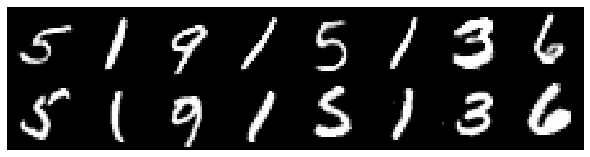

In [24]:
plot_reconstr(decoder)

Visualize the latent space distribution.

In [25]:
matplotlib.style.use("ggplot")


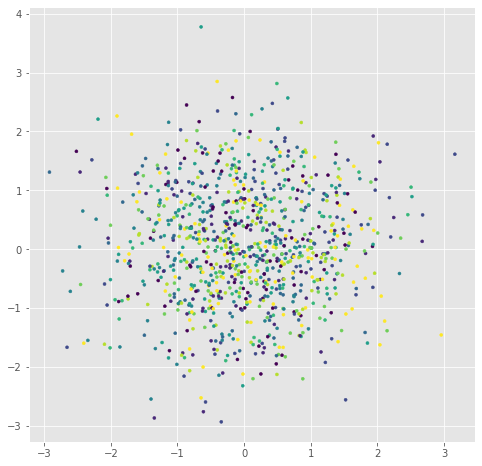

In [26]:
hidden_repr = encoder([datax[:1000,:,:,np.newaxis], labels[:1000]])
plt.figure(figsize=(8,8))
plt.scatter(hidden_repr[:,0], hidden_repr[:,1], c=np.argmax(labels[:1000], axis=1), marker=".")

And finally try to perfrom style transfer from the reference images (plot in the first column) to the images of all other classes.

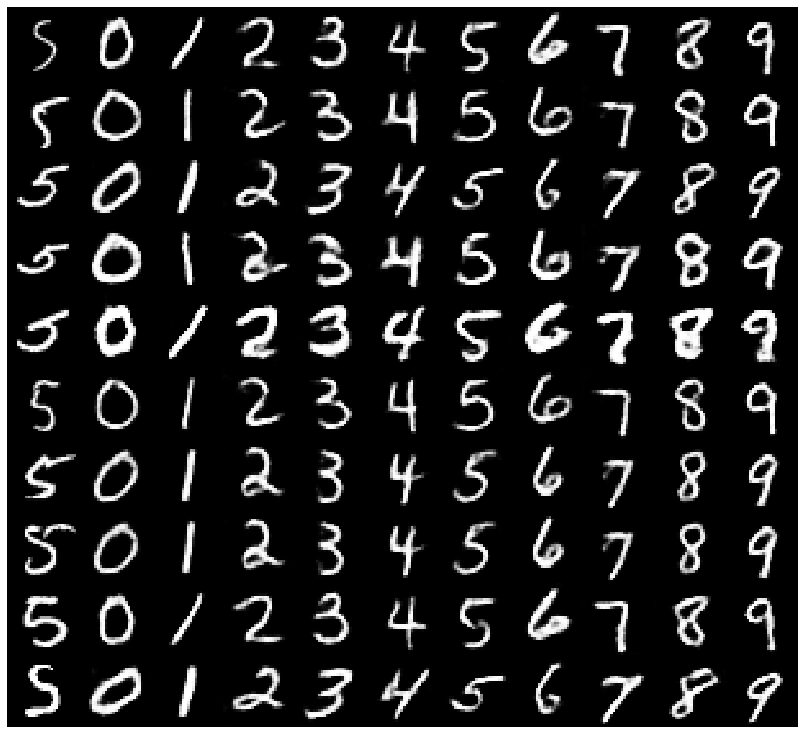

In [27]:
np.random.seed(15)
ref_label = 5
sample_idx = np.random.choice(np.where(np.argmax(labels, axis=1)==ref_label)[0], size=10)
samples = datax[sample_idx]

idx=1
plt.figure(figsize=(11,10))
for ref_im in samples:
    style = encoder.predict([ref_im[np.newaxis,:,:,np.newaxis], tf.keras.utils.to_categorical([ref_label], 10)])
    plt.subplot(10,11,idx)
    plt.imshow(np.squeeze(ref_im), cmap="gray")
    plt.axis("off")

    idx+=1
    for label in np.flip(np.unique(labels, axis=0), axis=1):
        im = decoder([style, label[np.newaxis,:]]).numpy()
        plt.subplot(10,11,idx)
        plt.imshow(np.squeeze(im), cmap="gray")
        plt.axis("off")
        idx+=1
plt.tight_layout(0)